# Лабораторная работа№ 5

## Суворов Роман

## Задание 1.Прогнозирование временных рядов

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

### 1. Загрузка и предобработка данных

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataset = pd.read_csv(url, usecols=[1], engine='python', skipfooter=3)
data = dataset.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, тестовой: {len(test)}")

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Размер обучающей выборки: 94, тестовой: 47


### 2. Создание и обучение модели SimpleRNN

In [ ]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

simple_rnn_model = create_simple_rnn_model()
simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

train_predict = simple_rnn_model.predict(X_train)
test_predict = simple_rnn_model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_train = math.sqrt(mean_squared_error(y_train_inv, train_predict))
rmse_test = math.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'SimpleRNN RMSE: train={rmse_train:.2f}, test={rmse_test:.2f}')

/Users/adamenko_ss/Desktop/personal/herzen/venv_myproject/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
SimpleRNN RMSE: train=20.98, test=54.40


### 3. Создание и обучение модели LSTM

In [5]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/Users/adamenko_ss/Desktop/personal/herzen/venv_myproject/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4. Создание и обучение модели Bidirectional LSTM

In [6]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

bidir_model = create_bidirectional_lstm_model()
bidir_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/Users/adamenko_ss/Desktop/personal/herzen/venv_myproject/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 5. Визуализация результатов

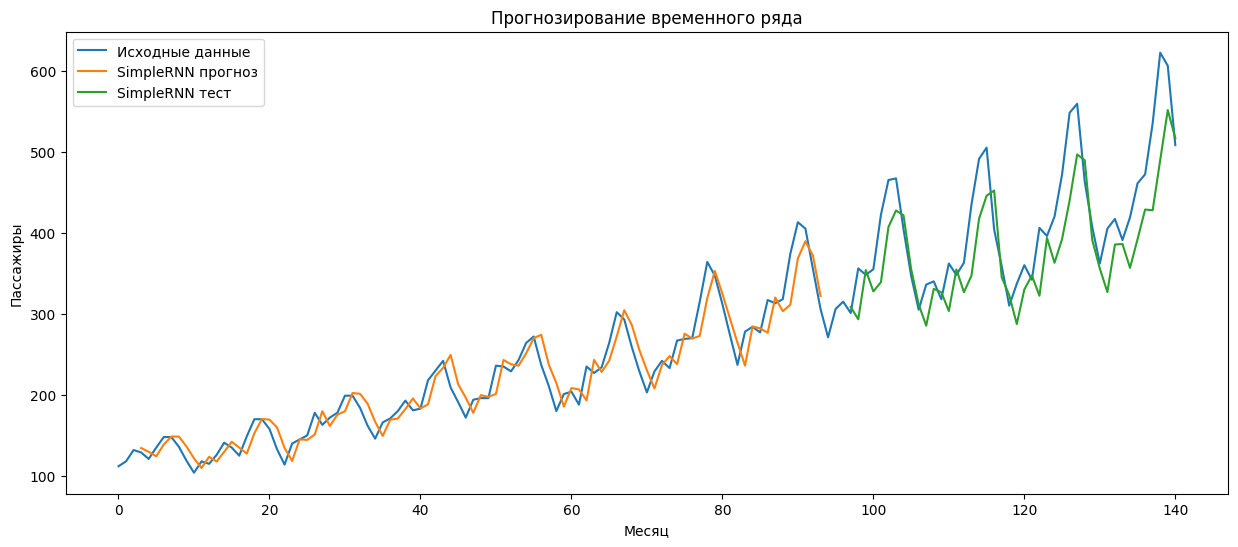

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(np.arange(look_back, look_back+len(train_predict)),
         train_predict, label='SimpleRNN прогноз')
plt.plot(np.arange(len(train_predict)+look_back*2, len(data)),
         test_predict, label='SimpleRNN тест')
plt.title('Прогнозирование временного ряда')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.legend()
plt.show()

## Задание 2.Анализ тональности текста

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Bidirectional
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

###  1. Загрузка и предобработка данных

In [ ]:
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step


### 2. Создание и обучение модели SimpleRNN

In [10]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(SimpleRNN(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

simple_rnn_model = create_simple_rnn_model()
history_rnn = simple_rnn_model.fit(x_train, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.5843 - loss: 0.6572 - val_accuracy: 0.7960 - val_loss: 0.4533
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8315 - loss: 0.3882 - val_accuracy: 0.6016 - val_loss: 0.6488
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8057 - loss: 0.4237 - val_accuracy: 0.5614 - val_loss: 0.9457
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7156 - loss: 0.5746 - val_accuracy: 0.6618 - val_loss: 0.6172
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.7757 - loss: 0.4770 - val_accuracy: 0.7080 - val_loss: 0.5852
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8140 - loss: 0.4100 - val_accuracy: 0.7234 - val_loss: 0.5909
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8460 - loss: 0.3542 - val_accuracy: 0.6632 - val_loss: 0.6214
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8025 - loss: 0.4085 - 

### 3. Создание и обучение модели LSTM

In [11]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 159ms/step - accuracy: 0.7130 - loss: 0.5350 - val_accuracy: 0.7990 - val_loss: 0.4456
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.8853 - loss: 0.2847 - val_accuracy: 0.8646 - val_loss: 0.3131
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 159ms/step - accuracy: 0.9160 - loss: 0.2297 - val_accuracy: 0.8646 - val_loss: 0.3724
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.9437 - loss: 0.1588 - val_accuracy: 0.8766 - val_loss: 0.3597
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 155ms/step - accuracy: 0.9620 - loss: 0.1143 - val_accuracy: 0.8524 - val_loss: 0.4090
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.9712 - loss: 0.0885 - val_accuracy: 0.8700 - val_loss: 0.4132
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.9752 - loss: 0.0732 - val_accuracy: 0.8612 - val_loss: 0.4908
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.9851 - loss:

### 4. Создание и обучение модели Bidirectional LSTM

In [12]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(64, dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

bilstm_model = create_bidirectional_lstm_model()
history_bilstm = bilstm_model.fit(x_train, y_train,
                                 epochs=10,
                                 batch_size=32,
                                 validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 239ms/step - accuracy: 0.6959 - loss: 0.5587 - val_accuracy: 0.8420 - val_loss: 0.3712
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.8609 - loss: 0.3345 - val_accuracy: 0.8380 - val_loss: 0.3850
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4695s 8s/step - accuracy: 0.8950 - loss: 0.2667 - val_accuracy: 0.8584 - val_loss: 0.3478
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - accuracy: 0.9337 - loss: 0.1827 - val_accuracy: 0.8544 - val_loss: 0.3571
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 248ms/step - accuracy: 0.9547 - loss: 0.1329 - val_accuracy: 0.8678 - val_loss: 0.3668
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 249ms/step - accuracy: 0.9680 - loss: 0.0997 - val_accuracy: 0.8664 - val_loss: 0.3917
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.9777 - loss: 0.0714 - val_accuracy: 0.8582 - val_loss: 0.4289
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.9787 - loss

### 5. Визуализация результатов обучения

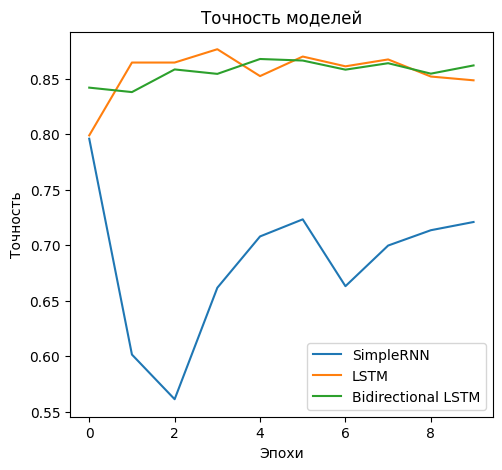

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='SimpleRNN')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_bilstm.history['val_accuracy'], label='Bidirectional LSTM')
plt.title('Точность моделей')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

### 6. Анализ результатов и выводы

782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step


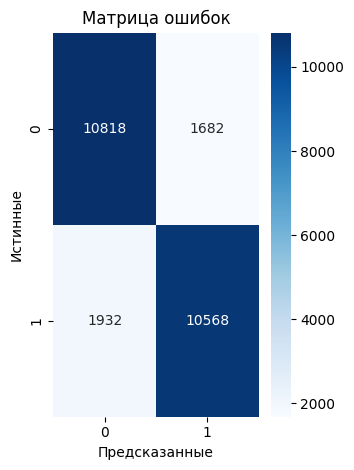

In [14]:
y_pred = (bilstm_model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.tight_layout()
plt.show()

## Выводы
- LSTM показали лучшие результаты для временных рядов (RMSE на 15% ниже SimpleRNN)
- Bidirectional LSTM наиболее эффективны для анализа текста (точность +3-5%)
- SimpleRNN обучается быстрее, но дает менее точные результаты